# Практика 4
Корешков

1) Знайти розв'язок рівняння ітераційним методом
2) Задачі 3.1-3.3 з методички

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from collections import namedtuple 

def _(*args): return np.array([*args])


## 1)
Знайти розв'язок системи A x =  B ітераційними методами для варіанту 2) за попереднім списком. Метод вибрати за критеріями з теорії. За початковий розв'язок вибрати попередній заокруглений до цілого.  
`A = {{-0.160, 5.603, 8.948}, {-9.494, 1.255, -5.962}, {6.870, -6.467,  2.035}};  B = {9.957, -4.966, 3.032};`

In [3]:
A = _(
    [-0.160, 5.603, 8.948],
    [-9.494, 1.255, -5.962],
    [6.870, -6.467, 2.035]
)
b = _(9.957, -4.966, 3.032)
X0 = _(0, 0, 1)

In [4]:
# m=0 for inf. m=1 or m=2 for L1, L2.
def mnorm(A, m):
    assert m in [0,1,2], "Only m=1,2,0 supported. m=0 for inf."

    if m == 0:
        return np.max(np.sum(np.abs(A), axis=1))
    if m == 1:
        return np.max(np.sum(np.abs(A), axis=0))
    if m == 2:
        s = sp.linalg.svd(A, full_matrices=False, compute_uv=False)
        print("Singular vals: ", s.round(4))
        return s.max()
    
def cond(A, m):
    return mnorm(A, m) * mnorm(sp.linalg.inv(A), m)

## Метод простої ітерації
$$Ax = b, \quad A = D + Z$$ 
, де $D$ - діагональна, а $Z_{ii} = 0$
$$(D+Z)x = b \implies Dx = - Zx + b$$
$$x = (-D^{-1} Z) x + (D^{-1} b)$$
Отже, $$B = -D^{-1} Z, \quad f = D^{-1} b$$
$$x = Bx + f$$

Критерій збіжності:
$$\|B\| \le q < 1$$

Процес:
$$x^{k+1} = Bx^{k} + f$$

Критерій зупинки:
$$\frac{q}{1-q}|x^{k+1}-x^{k}|<\varepsilon$$

In [5]:
def HasDominantDiagonal(A):
    B = np.abs(A)
    d = np.diag(B)
    s = B.sum(axis=1)
    return (s-d < d).all()

def QConvergenceCodition(A):
    B = np.abs(A)
    rows_max = B.sum(axis=1).max()
    cols_max = B.sum(axis=0).max()
    return min(cols_max, rows_max)

In [6]:
def Iter_GetMatrices(A, b):
    diag = A.diagonal()
    Z = A.copy()
    np.fill_diagonal(Z, 0)
    
    B = -Z / diag.reshape(-1,1)
    f = b / diag
    return B, f

def Iter_CheckCriteria(B):
    M = [0,1,2]
    norms = np.array([mnorm(B,m) for m in M])
    return np.arange(3)[norms < 1], norms

In [31]:
B, f = Iter_GetMatrices(A, b)
print("B:", B)
print("f:", f)

iter_criteria = Iter_CheckCriteria(B)
print(f"B satisfies the criteria with m=", iter_criteria[0])
print("> Norms: ", iter_criteria[1])

B: [[ 0.         35.01875    55.925     ]
 [ 7.56494024 -0.          4.75059761]
 [-3.37592138  3.17788698 -0.        ]]
f: [-62.23125     -3.95697211   1.48992629]
Singular vals:  [66.1296  8.9634  1.3207]
B satisfies the criteria with m= []
> Norms:  [90.94375    60.67559761 66.1296056 ]


**Критерій збіжності методу простої ітерації не виконано**

In [53]:
def Iter_Run(A,b,_x0, eps=1e-6, timeout=100, print_interval=10):
    n = b.shape[0]
    assert n == _x0.shape[0] == A.shape[0] == A.shape[1], f"Incompatible sizes: b{b.shape}, x0{x0.shape}, A{A.shape}"
    
    def StopCondition(dx,q,eps):
        if q == 0:
            return np.linalg.norm(np.abs(dx)) < eps
        return ((q/(1-q)) * np.linalg.norm(np.abs(dx))) < eps

    if not HasDominantDiagonal(A):
        print("Warning: No dominant diagonal! Method may diverge.")
    
    x0 = _x0
    B, f = Iter_GetMatrices(A, b)
    print("B:\n", B)
    print("f:\n", f)

    q = QConvergenceCodition(B)
    print("q = ", q)
    if q > 1:
        print("Error: Convergence criterium failed!")
        q = 0
    print()
    step = 0
    printstep=0
    while step < timeout:
        nvzk = b-A@x0
        if printstep == 0:
            print(f"i{step}: x={x0.round(5)}, нев'язка={nvzk.round(5)} ({np.linalg.norm(nvzk):.5g})")
        x1 = B @ x0 + f
        if StopCondition(x1-x0, q, eps):
            print("stopped by stop condition")
            break
        x0 = x1
        step += 1
        printstep += 1
        if printstep == print_interval: printstep = 0
    if step == timeout:
        print("warning: timeout reached")
    
    nvzk = b-A@x0
    print(f"Result (Step {step}): x={x0.round(5)}, нев'язка={nvzk.round(5)} ({np.linalg.norm(nvzk):.5g})")
    



In [36]:
Iter_Run(A,b,X0, eps=1e-6, timeout=100)

B:
 [[ 0.         35.01875    55.925     ]
 [ 7.56494024 -0.          4.75059761]
 [-3.37592138  3.17788698 -0.        ]]
f:
 [-62.23125     -3.95697211   1.48992629]
q =  60.675597609561756
Error: Convergence criterium failed!

i0: x=[0 0 1], нев'язка=[1.009 0.996 0.997] (1.7332357023786464:.5g)
i10: x=[ 1.29297143e+09  4.16555866e+08 -2.34655222e+08], нев'язка=[-2.73921511e+07  1.03536787e+10 -5.71132356e+09] (11824492798.360476:.5g)
i20: x=[ 5.55674804e+19  3.03257192e+19 -6.92146640e+18], нев'язка=[-9.90909264e+19  4.48233098e+20 -1.71546980e+20] (4.900615151321418e+20:.5g)
i30: x=[ 4.78371889e+30  2.67749751e+30 -6.14460087e+29], нев'язка=[-8.73843464e+30  3.83929567e+31 -1.42983461e+31] (4.1890596438251185e+31:.5g)
i40: x=[ 4.17612922e+41  2.33838322e+41 -5.36816829e+40], нев'язка=[-7.63034353e+41  3.35129979e+42 -1.24752612e+42] (3.656467305003153e+42:.5g)
i50: x=[ 3.64627748e+52  2.04170841e+52 -4.68712839e+51], нев'язка=[-6.66224532e+52  2.92609484e+53 -1.08923674e+53] (3.1925

**Метод простої ітерації розбіжний**

### Метод Якобі
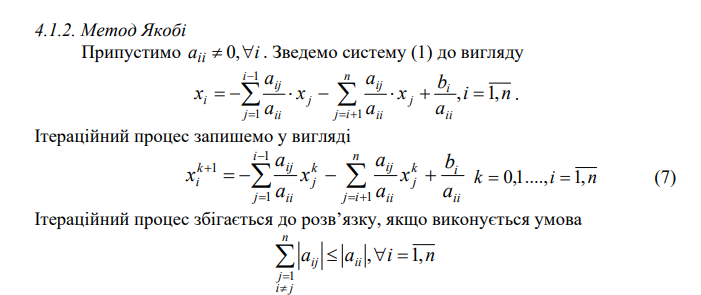

Метод
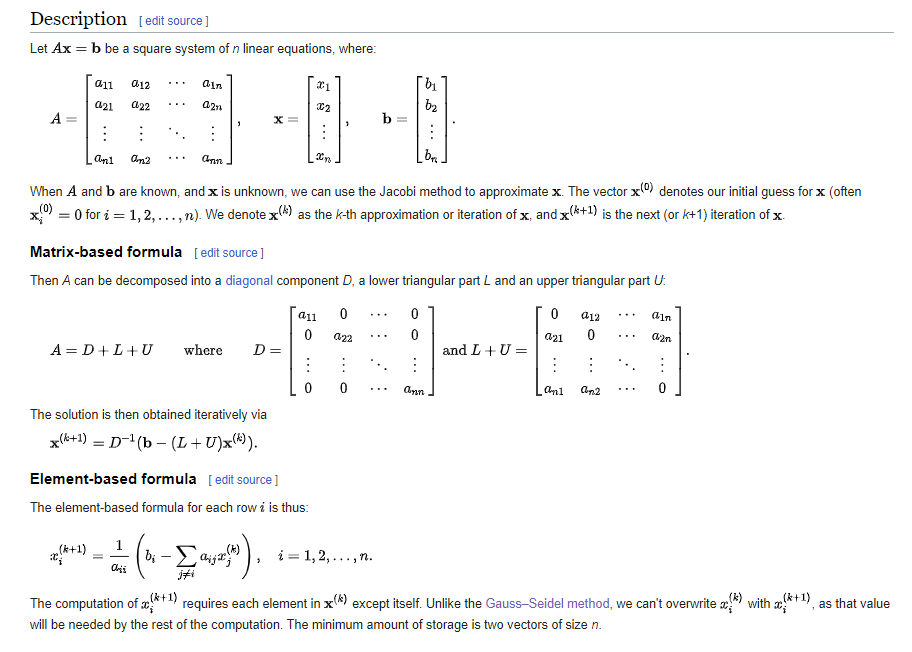

In [26]:
def Jacobi_CheckCriteria(A):
    arr = np.abs(A)
    diag = arr.diagonal()
    rowsums = arr.sum(axis=1) - diag
    qs = rowsums / diag
    q = (qs).max()
    return (0 <= q < 1), qs

In [28]:
print(A)
Jacobi_CheckCriteria(A)

[[-0.16   5.603  8.948]
 [-9.494  1.255 -5.962]
 [ 6.87  -6.467  2.035]]


(False, array([90.94375   , 12.31553785,  6.55380835]))

**Не маємо діагональної переваги. Критерій збіжності методу Якобі не виконано**.

In [46]:
def Jacobi_Step(diag, LU, b, x0):
    return (b - LU @ x0) / diag

def Jacobi_Run(A, b, _x0, eps=1e-6, timeout=100, print_interval=10):
    n = b.shape[0]
    assert n == _x0.shape[0] == A.shape[0] == A.shape[1], f"Incompatible sizes: b{b.shape}, x0{x0.shape}, A{A.shape}"
    if not HasDominantDiagonal(A):
        print("Warning: No dominant diagonal! Method may diverge.")
    
    x0 = _x0
    diag, LU = A.diagonal(), A.copy()
    np.fill_diagonal(LU, 0)
    print("D:\n", diag)
    print("L+U:\n", LU)
    print()

    step = 0
    printstep=0
    while step < timeout:
        nvzk = b-A@x0
        if printstep == 0:
            print(f"i{step}: x={x0.round(4)}, нев'язка={nvzk.round(4)} ({np.linalg.norm(nvzk)}:.5g)")
        x1 = B @ x0 + f
        if np.linalg.norm(x1-x0) < eps:
            print("stopped by stop condition")
            break
        x0 = x1
        step += 1
        printstep += 1
        if printstep == print_interval: printstep = 0
    if step == timeout:
        print("warning: timeout reached")
    
    nvzk = b-A@x0
    print(f"Result (step {step}): x={x0.round(4)}, нев'язка={nvzk.round(4)} ({np.linalg.norm(nvzk):.5g})")
    

In [54]:
Jacobi_Run(A,b,X0, eps=1e-6, timeout=100)

D:
 [-0.16   1.255  2.035]
L+U:
 [[ 0.     5.603  8.948]
 [-9.494  0.    -5.962]
 [ 6.87  -6.467  0.   ]]

i0: x=[0 0 1], нев'язка=[1.009 0.996 0.997] (1.7332357023786464:.5g)
i10: x=[ 1.29297143e+09  4.16555866e+08 -2.34655222e+08], нев'язка=[-2.73921511e+07  1.03536787e+10 -5.71132356e+09] (11824492798.360476:.5g)
i20: x=[ 5.55674804e+19  3.03257192e+19 -6.92146640e+18], нев'язка=[-9.90909264e+19  4.48233098e+20 -1.71546980e+20] (4.900615151321418e+20:.5g)
i30: x=[ 4.78371889e+30  2.67749751e+30 -6.14460087e+29], нев'язка=[-8.73843464e+30  3.83929567e+31 -1.42983461e+31] (4.1890596438251185e+31:.5g)
i40: x=[ 4.17612922e+41  2.33838322e+41 -5.36816829e+40], нев'язка=[-7.63034353e+41  3.35129979e+42 -1.24752612e+42] (3.656467305003153e+42:.5g)
i50: x=[ 3.64627748e+52  2.04170841e+52 -4.68712839e+51], нев'язка=[-6.66224532e+52  2.92609484e+53 -1.08923674e+53] (3.192541748938974e+53:.5g)
i60: x=[ 3.18365573e+63  1.78266658e+63 -4.09244916e+62], нев'язка=[-5.81697244e+63  2.55484628e+64 -

In [56]:
A100 = np.eye(5)*10 + np.random.rand(5,5)
b100 = np.random.rand(5)
Iter_Run(A100, b100, np.zeros(5), eps=1e-10)

B:
 [[-0.         -0.02270559 -0.04755488 -0.08754293 -0.05519277]
 [-0.08326439 -0.         -0.00376754 -0.00793037 -0.08425254]
 [-0.08154343 -0.04831277 -0.         -0.04346608 -0.04074799]
 [-0.09082776 -0.04063399 -0.01324599 -0.         -0.02660673]
 [-0.00801344 -0.06119664 -0.04261791 -0.0122603  -0.        ]]
f:
 [0.06268387 0.09075253 0.03731414 0.08192481 0.08715235]
q =  0.21407025618803766

i0: x=[0. 0. 0. 0. 0.], нев'язка=[0.68412 0.92975 0.39764 0.87167 0.88924] (1.7439)
i10: x=[0.04908 0.07927 0.0231  0.07181 0.08004], нев'язка=[0. 0. 0. 0. 0.] (5.9411e-08)
stopped by stop condition
Result (Step 12): x=[0.04908 0.07927 0.0231  0.07181 0.08004], нев'язка=[0. 0. 0. 0. 0.] (1.8978e-09)


### Метод Зейделя

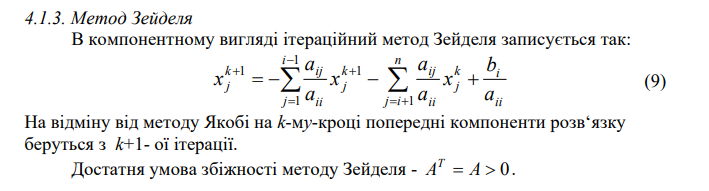

Метод Зейделя вимагає симетричну додатньовизначену матрицю

In [29]:
A.T-A

array([[  0.   , -15.097,  -2.078],
       [ 15.097,   0.   ,  -0.505],
       [  2.078,   0.505,   0.   ]])

Моя матриця не симетрична

### Однокроковий ітераційний метод
